In [1]:
import pygimli as pg
import pygimli.meshtools as mt
import pygimli.physics.traveltime as tt
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [3]:
data = pg.DataContainer("data.dat", "s g")
print(data)

Data: Sensors: 32 data: 220, nonzero entries: ['a', 'err', 'g', 's', 't', 'valid']


(<Axes: >, None)

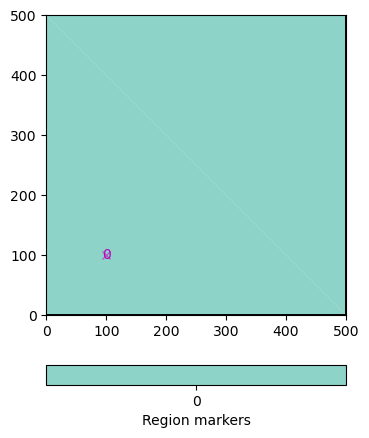

In [4]:
bh_spacing = 500
bh_length = 500
sensor_spacing = 10
world = mt.createRectangle(start=[0, (bh_length + 0.01)],
                           end=[bh_spacing, 0.0],
                           marker=0)

pg.show(world)

In [5]:
refinement = 1
x = np.arange(0, bh_spacing + refinement, sensor_spacing * refinement)
y = np.arange(0.0, bh_length + 3, sensor_spacing * refinement)
mesh = pg.meshtools.createGrid(x, y)
# ax, _ = pg.show(mesh, hold=True)

In [6]:
mgr = tt.TravelTimeManager()
# mgr.applyData(data)
invmodel = mgr.invert(data, mesh=mesh, secNodes=3, lam=800, zWeight=1,
                      useGradient=False, verbose=False)


23/06/23 - 16:08:33 - pyGIMLi - INFO - Found 1 regions.
23/06/23 - 16:08:33 - pyGIMLi - INFO - Creating forward mesh from region infos.
23/06/23 - 16:08:33 - pyGIMLi - INFO - Creating refined mesh (secnodes: 3) to solve forward task.
23/06/23 - 16:08:33 - pyGIMLi - INFO - Create constant starting model: 0.0001626613894710009
23/06/23 - 16:08:33 - pyGIMLi - INFO - Created startmodel from forward operator: 2500 [0.0001626613894710009,...,0.0001626613894710009]


Could not set x/y label:  220 [10.0,...,31.0] 220 [0.0,...,9.0]


Text(0, 0.5, 'Shot index')

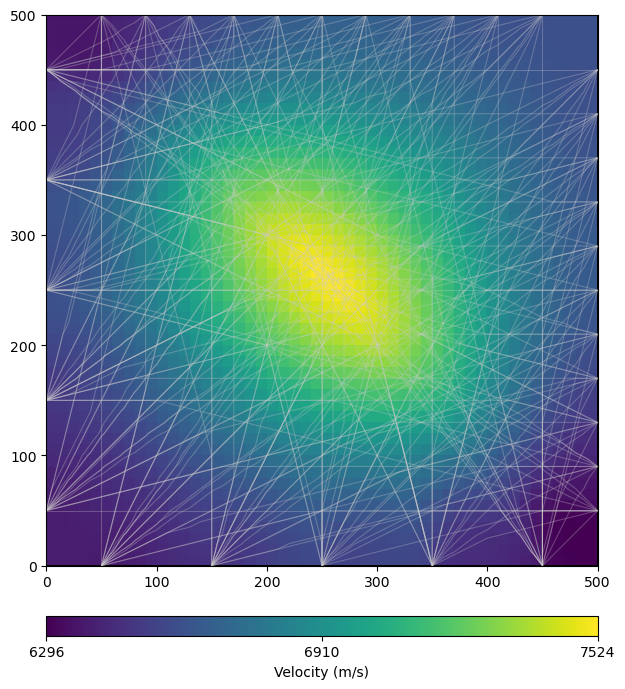

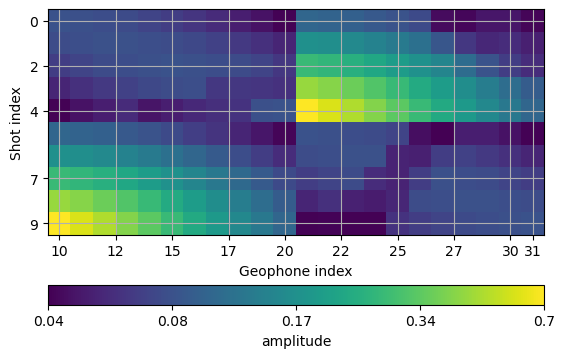

In [7]:
fig, ax2 = plt.subplots(1, 1, figsize=(8, 7), sharex=True, sharey=True)

mgr.showResult(ax=ax2, logScale=False, nLevs=3)
mgr.drawRayPaths(ax=ax2, color="0.8", alpha=0.3)
fig.tight_layout()

dist = tt.shotReceiverDistances(data, full=True)
ax, cb = pg.viewer.mpl.showDataContainerAsMatrix(data, "g", "s", "a",
                                                 label="amplitude")
ax.set_xlabel("Geophone index")
ax.set_ylabel("Shot index")

0.04027404788098587 0.7021885013265596
Could not set x/y label:  220 [10.0,...,31.0] 220 [0.0,...,9.0]


Text(0, 0.5, 'Shot index')

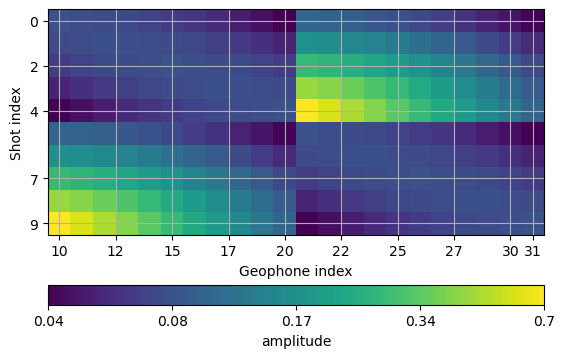

In [9]:
J = mgr.fop.jacobian()
amp = np.exp(-J.mult(np.ones(mesh.cellCount())*0.005))
print(min(amp), max(amp))
appAtt = - np.log(data["a"]) / dist
ax, cb = pg.viewer.mpl.showDataContainerAsMatrix(data, "g", "s",
                                                 # appAtt, label="app att")
                                                 amp, label="amplitude")
ax.set_xlabel("Geophone index")
ax.set_ylabel("Shot index")

In [14]:
fAtt=pg.frameworks.LinearModelling(J)  #Get jacobian from Travel Time
fAtt.setMesh(mesh)
att = pg.Vector(mesh.cellCount(), 0.01)
tLog = pg.trans.TransLog()
fAtt.modelTrans = tLog
inv = pg.Inversion(fop=fAtt)
inv.transModel = tLog
dataVec = - np.log(data["a"])
error = np.ones_like(dataVec) * 0.01
modelAmp = inv.run(dataVec, error, verbose=True)

23/06/23 - 16:14:19 - pyGIMLi - INFO - Use median(data values)=2.536931687685299
23/06/23 - 16:14:19 - pyGIMLi - INFO - Created startmodel from forward operator: 2500 [2.536931687685299,...,2.536931687685299]
23/06/23 - 16:14:19 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.frameworks.modelling.LinearModelling object at 0x000001BC1E596AE0>
Data transformation: <pgcore._pygimli_.RTrans object at 0x000001BBA9B1F6A0>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x000001BC1E574CC0>
min/max (data): 0.35/3.22
min/max (error): 1%/1%
min/max (start model): 2.54/2.54
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 1 ... chi² = 412326855.33 (dPhi = 83.44%) lam: 20
--------------------------------------------------------------------------------
inv.iter 2 ... chi² = 56578632.2 (dPhi = 86.28%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² = 7528470.61 (dPhi = 86.69%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 4 ... chi² = 1146890.74 (dPhi = 84.77%) lam: 20.0
----------------------------------------

(<Axes: >, <matplotlib.colorbar.Colorbar at 0x1bc1e582340>)

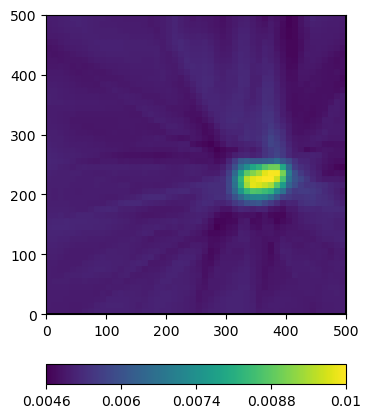

In [15]:
pg.show(mesh, modelAmp)